# Fannie Mae

In this code, we will be building a model to predict the net loss for a set of loans that Fannie Mae holds. This data set is very large, and you may get a popup at times saying that the "Kernel Died". If you do, that likely means you are out of memory. You will be able to use a larger virtual machine to work with this data, but depending on how many variables you use and how much feature engineering you do, you may still run out of memory on the larger machine.

If you choose to work on this data with the larger virtual machine, please be very conscious about logging out after you finish (by going to "File -> Log Out" in the toolbar). That will allow the virtual machine to be shut down as soon as you are done with it, saving the university money.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill
import random

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from xgboost import XGBRegressor

from patsy import dmatrices, dmatrix, build_design_matrices

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load the Data 

Before we load the data, we will find it helpful to specify the data type for each of the data fields in the data set. Much like in the preprocessing step when working with the Fannie Mae data, specifying the data types allows pandas to much more efficiently load and store the data, speeding up the data load process and more efficiently using system memory.

To specify the data types, we refer both to the data dictionary (available [here](https://capitalmarkets.fanniemae.com/media/6931/display)) as well as refer to our preprocessing code to specify the data types for the new data fields that we created for our analysis.

In [3]:
col_classes = {"LOAN_IDENTIFIER": np.character, 
               "CHANNEL": 'category', 
               "SELLER_NAME": np.character, 
               "ORIGINAL_INTEREST_RATE": np.float32, 
               "ORIGINAL_UPB": np.float64,
               "ORIGINAL_LOAN_TERM": "Int16", 
               "ORIGINATION_DATE": np.character,
               "FIRST_PAYMENT_DATE": np.character, 
               "ORIGINAL_LTV": np.float32, 
               "ORIGINAL_COMBINED_LTV": np.float32, 
               "NUMBER_OF_BORROWERS": 'category', 
               "DTI": np.float32, 
               "BORROWER_CREDIT_SCORE_AT_ORIGINATION": "UInt16", 
               "COBORROWER_CREDIT_SCORE_AT_ORIGINATION": 'UInt16', 
               "FIRST_TIME_HOME_BUYER_INDICATOR": 'category', 
               "LOAN_PURPOSE": 'category', 
               "PROPERTY_TYPE": 'category',
               "NUMBER_OF_UNITS": "UInt16", 
               "OCCUPANCY_STATUS": 'category', 
               "PROPERTY_STATE": 'category', 
               "MSA": 'category', 
               "ZIP_CODE_SHORT": 'category', 
               "MORTGAGE_INSURANCE_PERCENTAGE": np.float32, 
               "AMORTIZATION_TYPE": np.character,
               "MORTGAGE_INSURANCE_TYPE": 'category', 
               "RELOCATION_MORTGAGE_INDICATOR": 'category',
               "CREDIT_SCORE_MIN": "UInt16",
               "ORIGINAL_VALUE": float,
               "ZERO_BALANCE_CODE": 'category',
               "LOAN_AGE": "Int16",
               "NET_LOSS": float,
               "NET_SEVERITY": float,
               "LAST_STAT": 'category',
               "LOAN_MODIFICATION_COSTS": float,
               "TOTAL_LOSSES": float,
               "MSA_NAME": 'category',
               "CENSUS_2010_POP": float}

date_columns = ["ORIGINATION_DATE",
                "FIRST_PAYMENT_DATE"]

Here we load the data. There are two pre-built data sets. The first is a 2% random sample of the full data set (split into training and testing), and it is about 500,000 rows in each of the training and testing set (or almost 1,000,000 rows total). The full data set is about 50,000,000 rows with 90% of the data being training and the other 10% for testing. To load the full data set, you should just set the variable `full_data_set` to `True` like this:

``` python
full_data_set = True
```

There is also a variable `p` that will allow you to choose how much of the training set to load in. You may find it both very difficult and potentially unnecessary to use the full training set to build your models. If so, you can select any proportion of the data set that you would like to use by setting `p` equal to the proportion. I.e., `p=.1` means use 10% of the full training set. If you try to use the full data set, be prepared for many common things (like `summarize_dataframe()`) to take quite a long time.

In the test set, you have the realizations as well (i.e. the dependent variable `NET_LOSS` is in both the training and testing). This is because you will need to evaluate your model yourself given the size of the test set. The self-evaluated RMSE will be our benchmark for the competition.

In [4]:
%%time

full_data_set = False

FILES_LOCATION = '../Shared Data (Read Only)/Fannie Mae Data/'

if not full_data_set:
    df_train = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTrain.csv",
                           index_col="LOAN_IDENTIFIER",
                           dtype=col_classes,
                           parse_dates=date_columns,
                           sep='|')
    df_test = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

if full_data_set:
    # This p is the proportion of the training data you load.
    # You can set it anywhere from 0 to 1.
    p = 1
    random.seed(201)
    df_train = pd.read_csv(FILES_LOCATION + "FannieMaeTrain.csv",
                           index_col="LOAN_IDENTIFIER",
                           dtype=col_classes,
                           parse_dates=date_columns,
                           sep='|',
                           skiprows=lambda i: i>0 and random.random() > p)
    df_test = pd.read_csv(FILES_LOCATION + "FannieMaeTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

CPU times: user 5.91 s, sys: 377 ms, total: 6.29 s
Wall time: 6.39 s


In [5]:
df_train.shape

(493073, 36)

In [6]:
df_test.shape

(493073, 36)

In [7]:
df_train.columns

Index(['CHANNEL', 'SELLER_NAME', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_UPB',
       'ORIGINAL_LOAN_TERM', 'ORIGINATION_DATE', 'FIRST_PAYMENT_DATE',
       'ORIGINAL_LTV', 'ORIGINAL_COMBINED_LTV', 'NUMBER_OF_BORROWERS', 'DTI',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'FIRST_TIME_HOME_BUYER_INDICATOR', 'LOAN_PURPOSE', 'PROPERTY_TYPE',
       'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS', 'PROPERTY_STATE', 'MSA',
       'ZIP_CODE_SHORT', 'MORTGAGE_INSURANCE_PERCENTAGE', 'AMORTIZATION_TYPE',
       'MORTGAGE_INSURANCE_TYPE', 'RELOCATION_MORTGAGE_INDICATOR',
       'CREDIT_SCORE_MIN', 'ORIGINAL_VALUE', 'ZERO_BALANCE_CODE', 'LOAN_AGE',
       'NET_LOSS', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS',
       'TOTAL_LOSSES', 'MSA_NAME', 'CENSUS_2010_POP'],
      dtype='object')

## Summarize the Data

As we have done many times by now, we are going to summarize the data, see what missing values look like, and get a sense for what is a continuous variable and what is a categorical variable. As we have seen before, just because a variable is a number (i.e. `int64` for integers or `float64` for real numbers), it doesn't mean it's continuous. For example, below we see that `NUMBER_OF_BORROWERS` has 8 unique values. Those values are all numbers, so it is a `float64` variable, but that variable really is the number of borrowers on the loan, which is better thought of as a categorical variable. So, you should dig into the data glossary from the [Fannie Mae website](https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html) (direct link to glossary is [here](https://capitalmarkets.fanniemae.com/media/6931/display)) in order to understand what these variables mean.

The data set contains all of the variables from the acquisition file, and we have pre-computed some additional independent variables (i.e. variables we can use to predict) that are not in the glossary:
  * `CREDIT_SCORE_MIN`: The minimum of the borrower and the co-borrowers credit score.
  * `ORIGINAL_VALUE`: The original value of the house. Computed from `ORIGINAL_LTV` (original loan to value) and `ORIGINAL_UPB` (original unpaid balance).
  * `MSA_NAME`: The name of the MSA.
  * `CENSUS_2010_POP`: The population in 2010 for the MSA.
  
We have also pulled in or pre-computed a number of variables that we cannot use for our prediction. This is because these variables are computed from the performance data while we are computing our dependent variable and if we used them, this would be future data leaking into the past (i.e. data we wouldn't have at decision time). These variables are:

  * `ZERO_BALANCE_CODE`: The code indicated in the data set for when the mortgage is at zero balance.
  * `LOAN_AGE`: The age of the loan in the data set.
  * `NET_LOSS`: The net loss of a loan that has experienced a credit event (i.e. default).
  * `NET_SEVERITY`: The net loss divided by the unpaid balance (i.e. percent loss).
  * `LAST_STAT`: a letter indicating the last status of the loan in the data set. The values are as follows:
      * `P`: Prepaid or matured loan.
      * `T`: Third party sale of loan.
      * `S`: Short sale.
      * `R`: Repurchased loan.
      * `F`: Deed-in-lieu of foreclosure.
      * `N`: Note sale.
      * `L`: Reperforming loan sale.
      * `X`: Loan is delinquent, but status is unknown.
      * `9`: The loan has been delinquent for at least 9 months.
      * `1`-`8`: The loan has been delinquent for this many months.
      * `C`: The loan is current.
  * `LOAN_MODIFICATION_COSTS`: Costs due to modifying loan terms (i.e. reducing interest rate or forgiving principle).
  * `TOTAL_LOSSES`: `NET_LOSS` plus `LOAN_MODIFICATION_COSTS`.

Here, we will be predicting `NET_LOSS`, so we will drop all other variables that are computed using the performance data to avoid the possibility of accidentally using them to build our model.

In [8]:
if 'ZERO_BALANCE_CODE' in df_train:
    df_train.drop(['ZERO_BALANCE_CODE', 'LOAN_AGE', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS', 'TOTAL_LOSSES'],
                  axis=1,
                  inplace=True)
if 'ZERO_BALANCE_CODE' in df_test:
    df_test.drop(['ZERO_BALANCE_CODE', 'LOAN_AGE', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS', 'TOTAL_LOSSES'],
                  axis=1,
                  inplace=True)

In [9]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all', datetime_is_numeric=True).transpose()], axis=1).fillna(""))

In [10]:
summarize_dataframe(df_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,category,0,3,493073.0,3,R,257680,,,,,,,
SELLER_NAME,object,0,143,493073.0,143,Other,180983,,,,,,,
ORIGINAL_INTEREST_RATE,float32,1,1960,493072.0,,,,4.917918,1.75,3.875,4.75,5.875,12.125,1.381413
ORIGINAL_UPB,float64,0,831,493073.0,,,,205186.96623,6000.0,116000.0,179000.0,269000.0,1269000.0,118997.809289
ORIGINAL_LOAN_TERM,Int16,0,204,493073.0,,,,310.4345,60.0,240.0,360.0,360.0,360.0,80.317014
ORIGINATION_DATE,datetime64[ns],0,267,493073.0,,,,2010-09-17 11:51:27.021191680,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,493073.0,,,,2010-11-17 13:53:54.489822208,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float32,0,96,493073.0,,,,70.482384,2.0,60.0,75.0,80.0,97.0,17.552217
ORIGINAL_COMBINED_LTV,float32,0,124,493073.0,,,,71.231705,2.0,61.0,75.0,80.0,158.0,17.620892
NUMBER_OF_BORROWERS,category,109,7,492964.0,7,2,273507,,,,,,,


In [11]:
summarize_dataframe(df_test)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,category,0,3,493073.0,3,R,257609,,,,,,,
SELLER_NAME,object,0,144,493073.0,144,Other,181007,,,,,,,
ORIGINAL_INTEREST_RATE,float32,0,1994,493073.0,,,,4.917481,1.75,3.875,4.75,5.875,11.625,1.384845
ORIGINAL_UPB,float64,0,844,493073.0,,,,205485.463613,8000.0,116000.0,179000.0,270000.0,1473000.0,119123.262314
ORIGINAL_LOAN_TERM,Int16,0,201,493073.0,,,,310.492996,60.0,240.0,360.0,360.0,360.0,80.312096
ORIGINATION_DATE,datetime64[ns],0,267,493073.0,,,,2010-09-17 05:33:07.161333248,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,493073.0,,,,2010-11-17 07:39:02.274673408,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float32,0,97,493073.0,,,,70.454559,1.0,60.0,75.0,80.0,97.0,17.539341
ORIGINAL_COMBINED_LTV,float32,0,127,493073.0,,,,71.187462,1.0,61.0,75.0,80.0,157.0,17.601181
NUMBER_OF_BORROWERS,category,101,9,492972.0,9,2,273611,,,,,,,


Notice that the training and test sets are practically identical (in fact they are practically the same size). Moreover, you have the realizations for each of the test data points. Given the size of the dataset, it is infeasible to submit predictions, so you will evaluate your performance directly on the test set. You should be wary of using the test set too much or you might overfit the test set.

## Engineer Row Based Features

As long as we don't need to use any information other than what we have, we can go ahead and engineer new features on the full training set. Here we will convert the `ORIGINATION_DATE` column from an object (i.e., string) to a formal datetime object in Python.

In [12]:
df_train['ORIGINATION_DATE'] = pd.to_datetime(df_train['ORIGINATION_DATE'], format='%Y-%m-%d')

df_test['ORIGINATION_DATE'] = pd.to_datetime(df_test['ORIGINATION_DATE'], format='%Y-%m-%d')

We will then use `ORIGINATION_DATE` to compute the year in which the loan was originated.

In [13]:
df_train['YEAR'] = df_train['ORIGINATION_DATE'].dt.year
df_test['YEAR'] = df_test['ORIGINATION_DATE'].dt.year

If you have any other features that you'd like to engineer that can be done with a single row, you can do that here as well.

## Split Into Training and Validation

Now we will split the train dataset into a smaller training and a validation set, as is best practice.

In [14]:
df_smaller_train, df_validation = train_test_split(df_train, test_size = 0.25, random_state = 201)

There is a bug that gives a warning later on in the code which you can fix by making copies of the above dataframe. This step is unnecessary, but it avoids showing a warning, so I'm going to include it.

In [15]:
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

## Impute Missing Values

We see that we have missing values among both continuous and categorical variables. We've seen how to impute missing values for continuous variables several times before. We generally take the mean of the data that is there, and then fill in the missing values with that mean. However, this may not always be the best option depending on the data, particularly if the fact that the data is missing is likely to be meaningful.

Imputing over categorical variables is challenging for three reasons. First, there are two equally reasonable ways to fill in missing values; you can either replace the missing values with the most common value in a category (for example "N" is the most common value for `FIRST_TIME_HOME_BUYER`, for any missing values in the dataset, you would replace it with "N"), or you can replace the value with some value that indicates it is missing (like the word "MISSING") and treat that like another category. The first method assumes that data is just accidentally missing, while the second assumes that there is something meaningful in it missing, which seems to be more common for categorical data than continuous data. As we've seen before `WheelTypeID` for the Carvana data set very much falls into this latter category of missing having meaning.

The second way in which categorical variables are challenging is that often times there are many, many values for a categorical variable, which means that there are very few data points associated with each category. A good example of this is `MSA` for which there are `406` unique values. The MSAs with few observations are unlikely to be predictive, but we may still want to include the MSAs with lots of observations and then lump everything else into an "OTHER" category. We also may want to do this either by the percentage of the dataset (e.g. any category that is less than 10% of the data should be lumped in other) or by the number of samples in the dataset (e.g. any category that has fewer than 1000 samples should be lumped in "OTHER").

The third reason that we imputing is challenging for categorical data is that the test set may have categories that we have never seen before. For example, if a city grows and a new MSA is added (or one is split), and we are trying to use the MSA to predict the expected `NET_LOSS`, then we won't have that MSA in the data we trained on. The simplest way to handle this is by lumping any of these observations into an "OTHER" category.

Unfortunately, there is not any pre-packaged transformer that will do all of these things for us. Fortunately, it's not hard to write a custom transformer that will do all of these things for us. I have done so below. Note that you do not need to understand how I wrote this. It will be sufficient to know how to use it.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom defined imputer for categorical data. This allows you to specify an 
    other class where any category that doesn't meet the requirements necessary to
    be in 
    """
    
    def __init__(self, other_threshold=0, 
                 other_label="OTHER",
                 missing_first=True,
                 missing_values=np.nan, 
                 strategy='constant', 
                 fill_value="MISSING", 
                 verbose=0, 
                 copy=True, 
                 add_indicator=False):
        self.add_indicator = add_indicator
        self.copy=copy
        self.verbose=verbose
        self.fill_value=fill_value
        self.missing_first=missing_first
        self.missing_values=missing_values
        self.other_label=other_label
        self.other_threshold=other_threshold
        self.strategy=strategy
        if hasattr(missing_values, "__iter__"):
            self.missing_values = missing_values
        else:
            self.missing_values = [missing_values]
        self._imputer = SimpleImputer(missing_values=missing_values, strategy=strategy, fill_value=fill_value, verbose=verbose, copy=copy, add_indicator=False)
        self._column_categories = {}

        
    def fit(self, X, y=None):
        if type(self.other_threshold) == int or type(self.other_threshold) == float:
            other_threshold = [self.other_threshold]*len(X.columns)
        elif len(self.other_threshold) == len(X.columns):
            other_threshold = self.other_threshold
        else:
            raise TypeError("other_threshold must be either a single number or a list of numbers equal to the number of columns.")

        i = 0
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        column_categories = {}
        for column in X.columns:
            if other_threshold[i] < 1:
                other_threshold[i] = other_threshold[i]*X[column].shape[0]
            
            value_counts = X[column].value_counts()
            categories = [category for category in value_counts.index if value_counts.loc[category] >= other_threshold[i]]
            if value_counts.iloc[-1] >= other_threshold[i]:
                categories[-1] = self.other_label
            else:
                categories.append(self.other_label)
            
            self._column_categories[column] = categories
            i = i + 1
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        for column in X.columns:
            X.loc[~X[column].isin(self._column_categories[column]) & ~X[column].isin(self.missing_values), column] = self.other_label
        return pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)[:].astype(str)

While the above block of text may look intimidating, you really do not need to understand the actual code. You should know how to use the code, and if you want to use this function in a different notebook, you should just copy and paste the above block of code.

To use `CategoricalImputer` you don't necessarily need to specify anything. If you just use it as follows:

```python
imputer=CategoricalImputer()
imputer.fit(X[["Categorical Column 1", "Categorical Column 2"]])
imputer.transform(X[["Categorical Column 1", "Categorical Column 2"]])
```

it will just replace all missing values (`np.nan`) with the word "MISSING". However, you can specify a few other helpful items:
  * `other_threshold`: This will set the threshold for which if there are any categories below the threshold, it will replace them with the word "OTHER. If you specify a number between 0 and 1, it will be interpreted as a fraction of the full data (so .1 will mean that the category has to make up at least 10% of the data to be included, otherwise it becomes "OTHER"). If you specify an integer, it will indicate the absolute number of rows that have to have that category (e.g. 1000 means that 1000 rows have to have that category or it gets grouped with "OTHER"). You can also specify a list that is as long as the number of columns you have (so if you are imputing over three columns, you need a list with three items), and the threshold for the column will correspond to the threshold in the same place in the list. **By default this is `0`.**
  * `other_label`: This sets the label for the other category. **By default this is `"OTHER"`.**
  * `missing_first`: If this is `True`, then missing values are imputed first and then the missing category is treated like any other category. This means that if the number of missing observations is below the threshold, it will be lumped into "OTHER". If this is `False`, then missing values will be imputed at the end, so you will know which values were missing even if there were only a few. **By default this is `True`.**

Finally, you can set all imputer values just like the `SimpleImputer` function where the documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). The defaults are `missing_values=np.nan, strategy='constant', fill_value="MISSING"`, which are generally reasonable for a categorical problem, but you may need to change things if a) your data already has a "MISSING" category, b) if your missing values are not indicated by `np.nan`, or c) you can replace `strategy='constant'` with `strategy='most_frequent'` if you would rather use the most frequent category to fill in.

This imputer will also set the least common class the value of `other_label` (by default "OTHER"). This allows any values that are in the test data, but not the training data to also be assigned to this "OTHER" category.

I find that it is very helpful to print the list of the columns names and then organize the column names into lists according to imputing strategy, typically at least one of continuous variables and one of categorical variables and potentially others if you want to impute using a different strategy. If you print the list first, you can copy and paste in order to avoid any accidental typos.

In [17]:
list(df_smaller_train.columns)

['CHANNEL',
 'SELLER_NAME',
 'ORIGINAL_INTEREST_RATE',
 'ORIGINAL_UPB',
 'ORIGINAL_LOAN_TERM',
 'ORIGINATION_DATE',
 'FIRST_PAYMENT_DATE',
 'ORIGINAL_LTV',
 'ORIGINAL_COMBINED_LTV',
 'NUMBER_OF_BORROWERS',
 'DTI',
 'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
 'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
 'FIRST_TIME_HOME_BUYER_INDICATOR',
 'LOAN_PURPOSE',
 'PROPERTY_TYPE',
 'NUMBER_OF_UNITS',
 'OCCUPANCY_STATUS',
 'PROPERTY_STATE',
 'MSA',
 'ZIP_CODE_SHORT',
 'MORTGAGE_INSURANCE_PERCENTAGE',
 'AMORTIZATION_TYPE',
 'MORTGAGE_INSURANCE_TYPE',
 'RELOCATION_MORTGAGE_INDICATOR',
 'CREDIT_SCORE_MIN',
 'ORIGINAL_VALUE',
 'NET_LOSS',
 'MSA_NAME',
 'CENSUS_2010_POP',
 'YEAR']

Here, we really need to be careful when we are imputing values. A missing value very well might be meaningful. For example, one of the columns that has missing values is `BORROWER_CREDIT_SCORE_AT_ORIGINATION`. Take a look at the data glossary [here](https://capitalmarkets.fanniemae.com/media/6931/display) to see what that means. What would you impute `BORROWER_CREDIT_SCORE_AT_ORIGINATION` as?

We will create a few different imputers to use.

In [18]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer = CategoricalImputer(other_threshold=.01)

We have an imputer that replaces missing values with the mean, one that replaces missing values with `0`, and one that imputes for categorical variables that lumps in categories that is less than 1% of the data in the `OTHER` category.

Let's make a list of which variables we would like to use on these.

In [19]:
continuous_mean = ['ORIGINAL_INTEREST_RATE',
                   'ORIGINAL_UPB',
                   'ORIGINAL_LOAN_TERM',
                   'ORIGINAL_LTV',
                   'ORIGINAL_COMBINED_LTV',
                   'DTI',
                   'ORIGINAL_VALUE',
                   'YEAR']

continuous_zero = ['MORTGAGE_INSURANCE_PERCENTAGE', 
                   'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
                   'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
                   'CREDIT_SCORE_MIN']

continuous_variables = continuous_mean + continuous_zero

categorical_variables = ['CHANNEL',
                         'SELLER_NAME',
                         'NUMBER_OF_BORROWERS',
                         'FIRST_TIME_HOME_BUYER_INDICATOR',
                         'LOAN_PURPOSE',
                         'PROPERTY_TYPE',
                         'NUMBER_OF_UNITS',
                         'OCCUPANCY_STATUS',
                         'PROPERTY_STATE',
                         'ZIP_CODE_SHORT',
                         'AMORTIZATION_TYPE',
                         'MORTGAGE_INSURANCE_TYPE',
                         'RELOCATION_MORTGAGE_INDICATOR',
                         'MSA',
                         'MSA_NAME',
                         'CENSUS_2010_POP']

Note that I list nearly all variables above between the three categories, even though many of the variables do not have missing values. This is because any variable that we want to include in the model will always have to have a complete set of data whenever we predict, and we never know when a new row in the data will come in that has a missing value you have never seen before. If we go ahead and fit imputers for all of the columns, then we can safely impute on this new row without missing a beat.

However, I do not have a few variables in there. First, I did not include `NET_LOSS`. This is the variable we are trying to predict, and we should never impute it. I also did not include `LOAN_IDENTIFIER`. This is because this is a unique value that identifies the loans, and if it is missing, then there is probably something wrong with that row of your data, and you should probably get an error if you try to predict on it.

I also leave out `ORIGINATION_DATE` because that is a `datetime` object and none of our imputers can handle it. Be careful using these as features in a model. Though if you create features based on them, you can likely impute on those just fine.

I chose to impute a zero to `MORTGAGE_INSURANCE_PERCENTAGE`, `BORROWER_CREDIT_SCORE_AT_ORIGINATION`, `COBORROWER_CREDIT_SCORE_AT_ORIGINATION`, and `CREDIT_SCORE_MIN`. Take a look at the data glossary to figure out why. Feel free to make a different choice if you think it would be better.

Now that we have identified our categories of variables, we can fit the imputers and transform the data.

In [20]:
imputer_mean.fit(df_smaller_train[continuous_mean])
df_smaller_train[continuous_mean] = imputer_mean.transform(df_smaller_train[continuous_mean])
df_validation[continuous_mean] = imputer_mean.transform(df_validation[continuous_mean])

In [21]:
imputer_zero.fit(df_smaller_train[continuous_zero])
df_smaller_train[continuous_zero] = imputer_zero.transform(df_smaller_train[continuous_zero])
df_validation[continuous_zero] = imputer_zero.transform(df_validation[continuous_zero])

In [22]:
categorical_imputer.fit(df_smaller_train[categorical_variables])
df_smaller_train[categorical_variables] = categorical_imputer.transform(df_smaller_train[categorical_variables])
df_validation[categorical_variables] = categorical_imputer.transform(df_validation[categorical_variables])

Now that we have imputed everything, we can check to see that we no longer have missing values.

In [23]:
summarize_dataframe(df_smaller_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,object,0,3,369804.0,3,R,193339,,,,,,,
SELLER_NAME,object,0,13,369804.0,13,Other,135691,,,,,,,
ORIGINAL_INTEREST_RATE,float64,0,1719,369804.0,,,,4.918824,1.75,3.875,4.75,5.875,12.125,1.381747
ORIGINAL_UPB,float64,0,820,369804.0,,,,204962.236752,6000.0,116000.0,178000.0,268000.0,1269000.0,118829.227289
ORIGINAL_LOAN_TERM,float64,0,196,369804.0,,,,310.443689,60.0,240.0,360.0,360.0,360.0,80.318952
ORIGINATION_DATE,datetime64[ns],0,267,369804.0,,,,2010-09-16 12:00:17.990070784,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,369804.0,,,,2010-11-16 14:03:52.001817088,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float64,0,96,369804.0,,,,70.468143,2.0,60.0,75.0,80.0,97.0,17.56641
ORIGINAL_COMBINED_LTV,float64,0,121,369804.0,,,,71.212096,2.0,61.0,75.0,80.0,149.0,17.625818
NUMBER_OF_BORROWERS,object,0,3,369804.0,3,2,205267,,,,,,,


## Set Up the Evaluation Metric

We will use RMSE, and only RMSE, to evaluate our models. You could definitely do more, but when we are working with the full data set, even just evaluating our models will take a while. It is always good to have a baseline to compare against. So, we will compare against just predicting the average `NET_LOSS` from our `df_train` data set, which we will call the "Naive" forecast.

In [24]:
average_loss = df_train['NET_LOSS'].mean()

In [25]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    RMSE = mean_squared_error(y_true, y_pred)**(1/2)
    naive_RMSE = mean_squared_error(y_true, [average_loss]*len(y_true))**(1/2)
    acc_df = pd.DataFrame(data = {"RMSE": [RMSE],
                                  "Naive - RMSE": [naive_RMSE - RMSE]})
    display(acc_df.style.hide_index())

So, a smaller `RMSE` is better and a higher `Naive - RMSE` is better.

## Linear Regression Feature Engineering

As we have seen, linear models like lasso or ridge regression typically require different kinds of features to be engineered from the variables. For example, we have seen that dummy variables are necessary in linear models, but not strictly necessary in tree based models (like regression trees and random forests). Additionally, interaction variables are the only way to get at certain effects in linear models, but tree based models can learn them directly. Another difference is with linear models you need to be more careful about is over-specifying the training data, i.e. if you have dummy variables you need to drop one column or the model is overspecified.

Therefore, it will be useful to do feature engineering separately for the two classes of models. Luckily `dmatrices` is a function that is very good at setting up data for a linear model. While we've used this a number of times before, [this](https://patsy.readthedocs.io/en/latest/formulas.html#) link about how formulas work may be very helpful in constructing more complicated features including interactions and transformations.

We will start by specifying the formula we are going to use to generate our data. Again, refer to the link above for a refresher on how formulas work.

In [26]:
formula_linear = "NET_LOSS ~ standardize(ORIGINAL_LTV) + standardize(DTI) + standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION) + FIRST_TIME_HOME_BUYER_INDICATOR + PROPERTY_STATE + standardize(YEAR) + FIRST_TIME_HOME_BUYER_INDICATOR*standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION)"

We by default have added four variables, and an interaction term. The five variables are `ORIGINAL_LTV`, `DTI`, `BORROWER_CREDIT_SCORE_AT_ORIGINATION`, `PROPERTY_STATE`, `YEAR`, and `FIRST_TIME_HOME_BUYER_INDICATOR`. Then we interact `FIRST_TIME_HOME_BUYER_INDICATOR` and `BORROWER_CREDIT_SCORE_AT_ORIGINATION` with `FIRST_TIME_HOME_BUYER_INDICATOR*BORROWER_CREDIT_SCORE_AT_ORIGINATION`. Note that we use the `standardize()` function for any continuous variables. Standardizing continuous variables can significantly improve the performance of a regularized regression model, and it's generally recommended. There is no need to standardize dummy variables, and all of the other variables currently in the formula are dummy variables.

Another useful aspect of standardizing variables is in interpreting coefficients. If we don't standardize, then variables with larger variance (like `BORROWER_CREDIT_SCORE_AT_ORIGINATION`) will necessarily have smaller coefficients because the number that multiplies the coefficients is just larger. Once all variables have been rescaled to have mean 0 and standard deviation of 1, we can say that the effect of one unit deviation from average is just the coefficient, which makes all the coefficients comparable.

Let's check to make sure our formula looks right (remember you have to get variable names exactly right, case and spelling are important!).

In [27]:
formula_linear

'NET_LOSS ~ standardize(ORIGINAL_LTV) + standardize(DTI) + standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION) + FIRST_TIME_HOME_BUYER_INDICATOR + PROPERTY_STATE + standardize(YEAR) + FIRST_TIME_HOME_BUYER_INDICATOR*standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION)'

Now we can build our X and y to train our model.

In [28]:
y_linear_train, X_linear_train = dmatrices(formula_linear, df_smaller_train, return_type="dataframe")

Let's look at what it made.

In [29]:
y_linear_train

,NET_LOSS
LOAN_IDENTIFIER,
366756076746,0.0
922055643120,0.0
567167163612,0.0
537298100693,0.0
414054555648,0.0
...,...
833696160226,0.0
943668997502,0.0
128751700926,0.0


The `y_linear_train` is just whether or not each loan defaulted. Let's look at `X_linear_train`.

In [30]:
X_linear_train

,Intercept,FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],PROPERTY_STATE[T.AZ],PROPERTY_STATE[T.CA],PROPERTY_STATE[T.CO],PROPERTY_STATE[T.CT],PROPERTY_STATE[T.FL],PROPERTY_STATE[T.GA],PROPERTY_STATE[T.IA],PROPERTY_STATE[T.IL],PROPERTY_STATE[T.IN],PROPERTY_STATE[T.LA],PROPERTY_STATE[T.MA],PROPERTY_STATE[T.MD],PROPERTY_STATE[T.MI],PROPERTY_STATE[T.MN],PROPERTY_STATE[T.MO],PROPERTY_STATE[T.NC],PROPERTY_STATE[T.NJ],PROPERTY_STATE[T.NV],PROPERTY_STATE[T.NY],PROPERTY_STATE[T.OH],PROPERTY_STATE[T.OR],PROPERTY_STATE[T.OTHER],PROPERTY_STATE[T.PA],PROPERTY_STATE[T.SC],PROPERTY_STATE[T.TN],PROPERTY_STATE[T.TX],PROPERTY_STATE[T.UT],PROPERTY_STATE[T.VA],PROPERTY_STATE[T.WA],PROPERTY_STATE[T.WI],standardize(ORIGINAL_LTV),standardize(DTI),standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER]:standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),FIRST_TIME_HOME_BUYER_INDICATOR[T.Y]:standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),standardize(YEAR)
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
366756076746,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.880553,2.469771,-1.885060,-0.0,-0.0,-1.361281
922055643120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.026650,-1.207118,0.510588,0.0,0.0,-1.065033
567167163612,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709773,0.407126,0.686955,0.0,0.0,1.008706
537298100693,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.449823,0.586486,-2.105518,-0.0,-0.0,-0.472536
414054555648,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.051334,-1.296799,0.246038,0.0,0.0,-1.361281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833696160226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.311284,-0.938078,-0.062604,-0.0,-0.0,-0.916909
943668997502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.542619,0.945207,-0.753373,-0.0,-0.0,0.860582
128751700926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.620603,0.048405,1.201358,0.0,0.0,0.119961


What we see is that it created an intercept column, it created dummy variables for `FIRST_TIME_HOME_BUYER` (though there are only two columns, when there are three possible values, that is because it automatically drops one column), it created 29 columns dummy variables for `STATE`, it adds columns for our other continuous variables, and it adds two columns interacting the dummy columns of `FIRST_TIME_HOME_BUYER` with `BORROWER_CREDIT_SCORE`. Note that it automatically created dummy columns because `FIRST_TIME_HOME_BUYER` is an `object` type of data (which it automatically classifies as categorical variables).

Notice that it treats `YEAR` as a continuous variable, which might be what we want, but we also might want to treat `YEAR` as a dummy variable. `YEAR` is a `float64` in our data set, so it automatically assumes it is a continuous variable. However, you can force it to treat it as a dummy by replacing `YEAR` in the formula with `C(YEAR)`. The `C()` forces the variable to be treated as a dummy no matter what type it is.

We will go ahead and build the validation matrix. In order to test on our validation set, we have to perform the _exact same transformations on it_. First, we will use our `build_design_matrices` function to get our `X_linear_validation` matrix. Remember the `y` values for the validation set are just `df_validation['NET_LOSS']`.

In [31]:
X_validation = build_design_matrices([X_linear_train.design_info], df_validation, return_type="dataframe")[0]

In [32]:
X_validation

,Intercept,FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],PROPERTY_STATE[T.AZ],PROPERTY_STATE[T.CA],PROPERTY_STATE[T.CO],PROPERTY_STATE[T.CT],PROPERTY_STATE[T.FL],PROPERTY_STATE[T.GA],PROPERTY_STATE[T.IA],PROPERTY_STATE[T.IL],PROPERTY_STATE[T.IN],PROPERTY_STATE[T.LA],PROPERTY_STATE[T.MA],PROPERTY_STATE[T.MD],PROPERTY_STATE[T.MI],PROPERTY_STATE[T.MN],PROPERTY_STATE[T.MO],PROPERTY_STATE[T.NC],PROPERTY_STATE[T.NJ],PROPERTY_STATE[T.NV],PROPERTY_STATE[T.NY],PROPERTY_STATE[T.OH],PROPERTY_STATE[T.OR],PROPERTY_STATE[T.OTHER],PROPERTY_STATE[T.PA],PROPERTY_STATE[T.SC],PROPERTY_STATE[T.TN],PROPERTY_STATE[T.TX],PROPERTY_STATE[T.UT],PROPERTY_STATE[T.VA],PROPERTY_STATE[T.WA],PROPERTY_STATE[T.WI],standardize(ORIGINAL_LTV),standardize(DTI),standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER]:standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),FIRST_TIME_HOME_BUYER_INDICATOR[T.Y]:standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),standardize(YEAR)
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102169114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.542619,-0.489677,1.098477,0.0,0.000000,1.453079
210781550974,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257985,0.317446,-2.531738,-0.0,-0.000000,-1.213157
294248201550,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.905238,0.945207,-1.752785,-0.0,-1.752785,-0.620660
722263576284,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542619,-0.489677,0.848624,0.0,0.000000,-0.768784
793835452090,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.652846,-0.758717,-1.135501,-0.0,-0.000000,-1.213157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107652543596,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.335969,-0.938078,-0.503521,-0.0,-0.000000,-1.361281
755239314120,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.827254,-0.938078,-0.371246,-0.0,-0.371246,0.860582
325854699557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.396523,0.945207,-0.870951,-0.0,-0.000000,1.008706


Now we can predict on the validation set after we have built out models.

## LASSO regression

We will jump straight into the LASSO regression, though you are welcome to try OLS by going back to previous code (you will have to import some more things).

Let's train our LASSO model. When you use the full data, this may take some time. You certainly can spend time tuning the `alpha` as well using `GridSearchCV` or any other method.

In [34]:
%%time
lasso_model = Lasso(alpha = 1, max_iter=1000000)
lasso_model.fit(X_linear_train, y_linear_train)

CPU times: user 921 ms, sys: 223 ms, total: 1.14 s
Wall time: 273 ms


Lasso(alpha=1, max_iter=1000000)

We can look at the size of the coefficients that it returned. Note that it is the absolute value of the coefficient that is most important. We can truly compare the size of the coefficients since the data has been scaled.

In [35]:
coef_df = pd.DataFrame({'Importance': lasso_model.coef_}, index=X_linear_train.columns)
coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

,Importance
PROPERTY_STATE[T.NV],1215.393946
PROPERTY_STATE[T.AZ],861.331005
PROPERTY_STATE[T.FL],847.071216
PROPERTY_STATE[T.MI],690.125304
PROPERTY_STATE[T.NJ],402.717443
FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],-380.158449
PROPERTY_STATE[T.IL],350.103917
PROPERTY_STATE[T.OH],332.020341
PROPERTY_STATE[T.TX],-321.528554
standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),-315.690053


In [36]:
lasso_pred = lasso_model.predict(X_validation)

In [37]:
accuracy(df_validation['NET_LOSS'], lasso_pred)

RMSE,Naive - RMSE
7423.417572,32.982064


Not great yet, but you can continue adding features and tuning using grid search.

Let's plot the predicted versus actual net loss. Our predictions don't look great. Why is that?

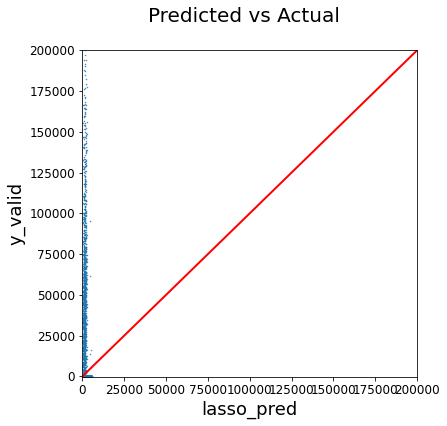

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(lasso_pred, df_validation['NET_LOSS'], s = 0.2)
plt.xlim(-100, 200000)
plt.ylim(-100, 200000)
plt.plot([-100, 200000], [-100, 200000], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('lasso_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

In the above plot, we are plotting the predicted value for the net loss with the actual realized value of the net loss. Ideally, we would want all of our predictions to lie on the red line. However, what we are really predicting is the _expected net loss_. Most mortgages don't default and therefore don't lose anything! The ones that do, lose a lot. So, the plot above is not giving us a very good read on the performance of our model.

In order to get a better sense for how our model actually does with predicting expected net loss, we should really bin the predictions and average over the realizations within the bins. This way if we predict that a certain bin of mortgages has an expected net loss of \$500, we can look at all mortgages that fall in that bin and see if there is indeed an _average_ net loss of around \$500. This is a much farer test for our model.

In the below block of code, we bin our predictions and then we average the realizations and we plot those. You can play around with the `lower_limit`, `upper_limit`, and `bin_size` in order to change exactly what is plotted.

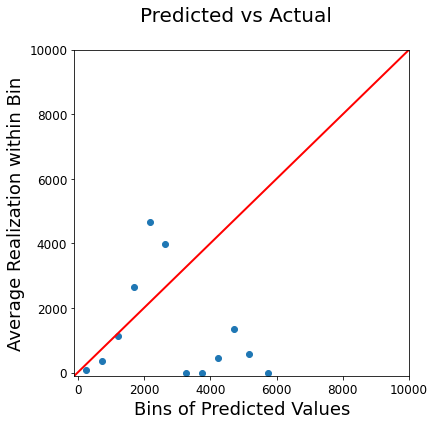

In [39]:
predictions = pd.Series(lasso_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

## Ridge regression

We will now train a ridge regression.

Let's train our LASSO model. When you use the full data, this may take some time. You certainly can spend time tuning the `alpha` as well using `GridSearchCV` or any other method.

In [40]:
%%time
ridge_model = Ridge(alpha = 1, max_iter=1000000)
ridge_model.fit(X_linear_train, y_linear_train)

CPU times: user 182 ms, sys: 23.1 ms, total: 206 ms
Wall time: 149 ms


Ridge(alpha=1, max_iter=1000000)

We can look at the size of the coefficients that it returned. Note that it is the absolute value of the coefficient that is most important. We can truly compare the size of the coefficients since the data has been scaled.

In [41]:
coef_df = pd.DataFrame({'Importance': ridge_model.coef_[0]}, index=X_linear_train.columns)
coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

,Importance
FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],2780.393578
PROPERTY_STATE[T.NV],1278.503794
PROPERTY_STATE[T.AZ],866.602851
PROPERTY_STATE[T.FL],837.002534
PROPERTY_STATE[T.MI],690.064521
FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER]:standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),605.732556
PROPERTY_STATE[T.NJ],410.431912
FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],-393.055494
PROPERTY_STATE[T.LA],-380.513456
PROPERTY_STATE[T.TX],-367.029497


In [42]:
ridge_pred = ridge_model.predict(X_validation)

In [43]:
accuracy(df_validation['NET_LOSS'], ridge_pred)

RMSE,Naive - RMSE
7423.329462,33.070174


Let's plot the binned predicted versus actual net loss.

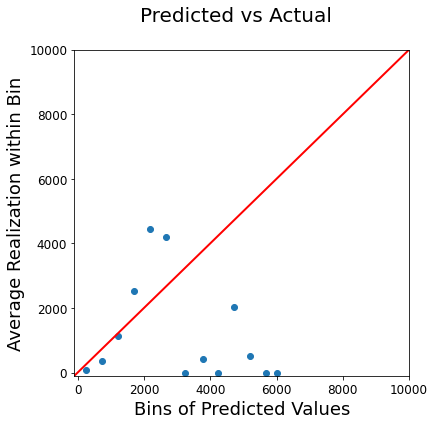

In [44]:
predictions = pd.Series(ridge_pred[:,0])
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

## Feature Engineering for Tree Based Models

In many ways, feature engineering is less important for tree based models. This is because tree based models can learn both interactions and how to pick out a single class. Think carefully about a) why it is unnecessary relative to logistic regression and b) why it might be harmful (particularly when you set `max_features` to something less than all features).

However, that does not mean that it is entirely irrelevant. First, we can let our trees do less work finding the most important relationships if we can construct some of them for it, and we can save some splitting that the tree would normally have to do if we provide some dummy variables. We can also help point it in the right direction if we provide some interactions.

Additionally, we can't just give our tree a list of strings (which is what a categorical variable is). Computers work with numbers so we need to use numbers. So, if we don't use dummy variables for a particular variable, we will still need to _encode_ it. The most common way is with an ordinal encoding scheme. Ordinal encoding assigns an integer to each category, and then that number replaces the original category. We can do this with the `OrdinalEncoder` function from `sklearn`. The `OrdinalEncoder` works just like the imputers we have seen before, but instead of imputing values it replaces categories with numbers so that the trees can work with them. Note that it is important to `.fit()` on your training data, and then use the _same encoder_ to `.transform()` the validation set (and later the testing set). If you re-fit the encoder on the validation or testing set, you may end up with categories being assigned to different numbers and your model would just be acting randomly on things.

First let's make a list of what to include broken up into three categories: continuous variables, ordinal encoded categorical variables, and dummy encoded categorical variables.

In [45]:
continuous_features_trees = ['ORIGINAL_LTV', 'DTI', 'BORROWER_CREDIT_SCORE_AT_ORIGINATION']
cat_ordinal_features_trees = ['PROPERTY_STATE']
cat_dummy_features_trees = ['FIRST_TIME_HOME_BUYER_INDICATOR']

Above we chose to create dummy variables for `FIRST_TIME_HOME_BUYER_INDICATOR` because there are only three possible values, but we are ordinal encoding `PROPERTY_STATE` because it would add 29 columns to our data if we tried to dummy encode it. That would throw off the random feature selection for things like random forests.

We can use these selected variables to make our training `X` matrix.

In [46]:
X_tree_train = df_smaller_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train = df_smaller_train['NET_LOSS']

That gives us the continuous features and the ordinal features, but we don't yet have the dummy features. The best way to get those is using the `dmatrix` command, which is really similar to `dmatrices`, but it doesn't give us back a `y` (which we already have from above. The syntax is very similar but we only specify the right hand side of the formula. For example, here we would do this.

In [47]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees)

In [48]:
formula_tree

'0 + FIRST_TIME_HOME_BUYER_INDICATOR'

The `0` above says don't add in an intercept. We can also easily add in interaction variables if we want to.

In [49]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees) + " + FIRST_TIME_HOME_BUYER_INDICATOR:BORROWER_CREDIT_SCORE_AT_ORIGINATION"

In [50]:
formula_tree

'0 + FIRST_TIME_HOME_BUYER_INDICATOR + FIRST_TIME_HOME_BUYER_INDICATOR:BORROWER_CREDIT_SCORE_AT_ORIGINATION'

Note that I used `:` when adding the interaction term `FIRST_TIME_HOME_BUYER_INDICATOR:BORROWER_CREDIT_SCORE_AT_ORIGINATION`. This tells `dmatrix` to just add the interaction, not the individual variables (which we already have in our model).

Now we can create our dummy variables and interactions easily.

In [51]:
X_tree_train_patsy = dmatrix(formula_tree, df_smaller_train, return_type="dataframe")

In [52]:
X_tree_train_patsy

,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[Y],FIRST_TIME_HOME_BUYER_INDICATOR[N]:BORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR[OTHER]:BORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR[Y]:BORROWER_CREDIT_SCORE_AT_ORIGINATION
LOAN_IDENTIFIER,,,,,,
366756076746,1.0,0.0,0.0,615.0,0.0,0.0
922055643120,1.0,0.0,0.0,778.0,0.0,0.0
567167163612,1.0,0.0,0.0,790.0,0.0,0.0
537298100693,1.0,0.0,0.0,600.0,0.0,0.0
414054555648,1.0,0.0,0.0,760.0,0.0,0.0
...,...,...,...,...,...,...
833696160226,1.0,0.0,0.0,739.0,0.0,0.0
943668997502,1.0,0.0,0.0,692.0,0.0,0.0
128751700926,1.0,0.0,0.0,825.0,0.0,0.0


It did exactly what we were expecting, but we need to add it to our `X_tree_train` to get everything in the same place. We can concatenate the two dataframes with `pd.concat()`.

In [53]:
X_tree_train = pd.concat([X_tree_train, X_tree_train_patsy], axis=1)

This added the two dataframes together, and we can check to make sure it is what we want.

In [54]:
X_tree_train

,ORIGINAL_LTV,DTI,BORROWER_CREDIT_SCORE_AT_ORIGINATION,PROPERTY_STATE,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[Y],FIRST_TIME_HOME_BUYER_INDICATOR[N]:BORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR[OTHER]:BORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR[Y]:BORROWER_CREDIT_SCORE_AT_ORIGINATION
LOAN_IDENTIFIER,,,,,,,,,,
366756076746,55.0,61.0,615.0,NJ,1.0,0.0,0.0,615.0,0.0,0.0
922055643120,70.0,20.0,778.0,OTHER,1.0,0.0,0.0,778.0,0.0,0.0
567167163612,58.0,38.0,790.0,CA,1.0,0.0,0.0,790.0,0.0,0.0
537298100693,45.0,40.0,600.0,IN,1.0,0.0,0.0,600.0,0.0,0.0
414054555648,52.0,19.0,760.0,TX,1.0,0.0,0.0,760.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
833696160226,65.0,23.0,739.0,MN,1.0,0.0,0.0,739.0,0.0,0.0
943668997502,80.0,44.0,692.0,UT,1.0,0.0,0.0,692.0,0.0,0.0
128751700926,42.0,34.0,825.0,OTHER,1.0,0.0,0.0,825.0,0.0,0.0


The final step is we need to ordinal encode any variables that are not dummies with `OrdinalEncoder`.

In [55]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_tree_train[cat_ordinal_features_trees])
X_tree_train[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_train[cat_ordinal_features_trees])

In [56]:
X_tree_train

,ORIGINAL_LTV,DTI,BORROWER_CREDIT_SCORE_AT_ORIGINATION,PROPERTY_STATE,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[Y],FIRST_TIME_HOME_BUYER_INDICATOR[N]:BORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR[OTHER]:BORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR[Y]:BORROWER_CREDIT_SCORE_AT_ORIGINATION
LOAN_IDENTIFIER,,,,,,,,,,
366756076746,55.0,61.0,615.0,17.0,1.0,0.0,0.0,615.0,0.0,0.0
922055643120,70.0,20.0,778.0,22.0,1.0,0.0,0.0,778.0,0.0,0.0
567167163612,58.0,38.0,790.0,2.0,1.0,0.0,0.0,790.0,0.0,0.0
537298100693,45.0,40.0,600.0,9.0,1.0,0.0,0.0,600.0,0.0,0.0
414054555648,52.0,19.0,760.0,26.0,1.0,0.0,0.0,760.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
833696160226,65.0,23.0,739.0,14.0,1.0,0.0,0.0,739.0,0.0,0.0
943668997502,80.0,44.0,692.0,27.0,1.0,0.0,0.0,692.0,0.0,0.0
128751700926,42.0,34.0,825.0,22.0,1.0,0.0,0.0,825.0,0.0,0.0


One final detail, xgboost does not like `[` or `]` in column names (e.g. `FIRST_TIME_HOME_BUYER_INDICATOR[N]`), so we will replace those with `(` and `)`.

In [57]:
X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_78/1300321592.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')


In [58]:
X_tree_train.columns

Index(['ORIGINAL_LTV', 'DTI', 'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'PROPERTY_STATE', 'FIRST_TIME_HOME_BUYER_INDICATOR(N)',
       'FIRST_TIME_HOME_BUYER_INDICATOR(OTHER)',
       'FIRST_TIME_HOME_BUYER_INDICATOR(Y)',
       'FIRST_TIME_HOME_BUYER_INDICATOR(N):BORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'FIRST_TIME_HOME_BUYER_INDICATOR(OTHER):BORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'FIRST_TIME_HOME_BUYER_INDICATOR(Y):BORROWER_CREDIT_SCORE_AT_ORIGINATION'],
      dtype='object')

Let's go ahead and transform our validation set.

In [59]:
X_tree_validation = df_validation[continuous_features_trees + cat_ordinal_features_trees]
y_tree_validation = df_validation['NET_LOSS']

X_tree_validation_patsy = build_design_matrices([X_tree_train_patsy.design_info], df_validation, return_type="dataframe")[0]

X_tree_validation = pd.concat([X_tree_validation, X_tree_validation_patsy], axis=1)

X_tree_validation[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_validation[cat_ordinal_features_trees])

X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_78/3653439084.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')


Now we are ready to start training trees.

## Decision Tree

In [60]:
%%time
dt_model = DecisionTreeRegressor(max_depth=10,
                                 min_samples_split=2500,
                                 max_features=.5,
                                 min_impurity_decrease=.1,
                                 random_state=201)
dt_model.fit(X_tree_train, y_tree_train)

CPU times: user 333 ms, sys: 12 ms, total: 345 ms
Wall time: 344 ms


DecisionTreeRegressor(max_depth=10, max_features=0.5, min_impurity_decrease=0.1,
                      min_samples_split=2500, random_state=201)

Let's plot our tree.

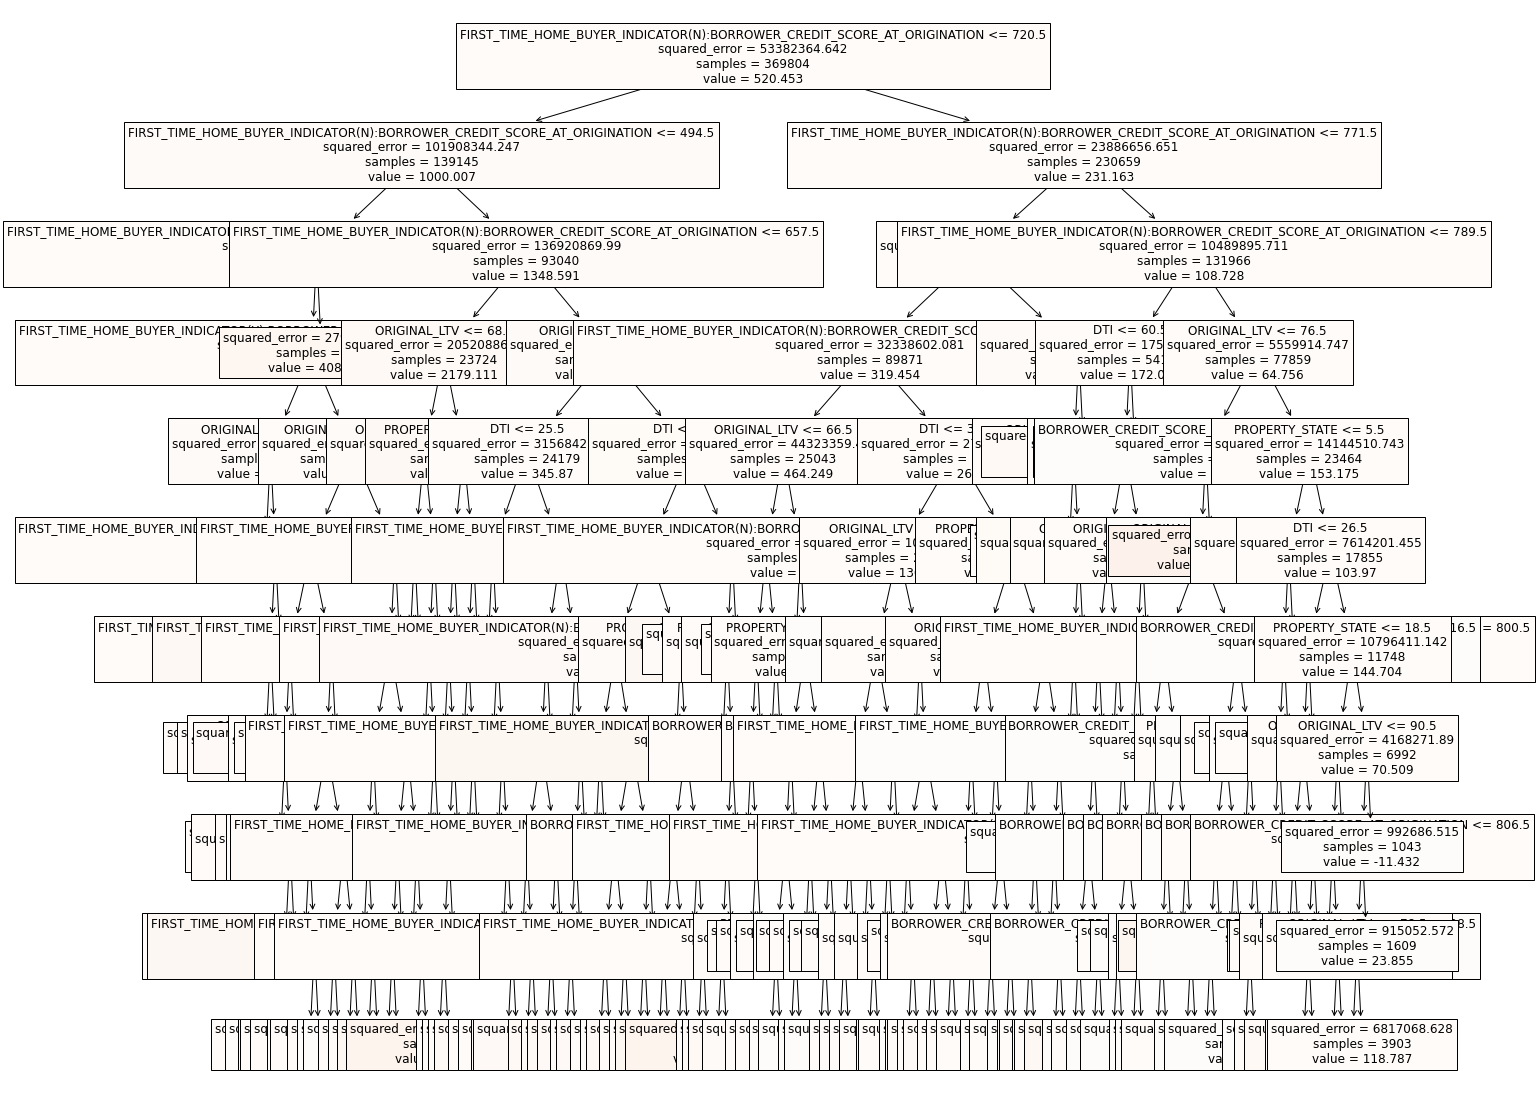

In [61]:
plt.figure(figsize=(20,20))
plot_tree(dt_model, feature_names=X_tree_train.columns, filled=True, fontsize=12)
plt.show()

We can also look at the feature importance.

In [62]:
pd.DataFrame({'Importance': dt_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
FIRST_TIME_HOME_BUYER_INDICATOR(N):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.409221
ORIGINAL_LTV,0.209375
DTI,0.205903
PROPERTY_STATE,0.138387
BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.020482
FIRST_TIME_HOME_BUYER_INDICATOR(Y):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.010879
FIRST_TIME_HOME_BUYER_INDICATOR(OTHER):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.005752
FIRST_TIME_HOME_BUYER_INDICATOR(N),0.000000
FIRST_TIME_HOME_BUYER_INDICATOR(OTHER),0.000000
FIRST_TIME_HOME_BUYER_INDICATOR(Y),0.000000


Now we can predict on our validation set.

In [63]:
dt_pred = dt_model.predict(X_tree_validation)

In [64]:
accuracy(df_validation['NET_LOSS'], dt_pred)

RMSE,Naive - RMSE
7425.946256,30.453380


Let's plot the binned predicted versus actual net loss.

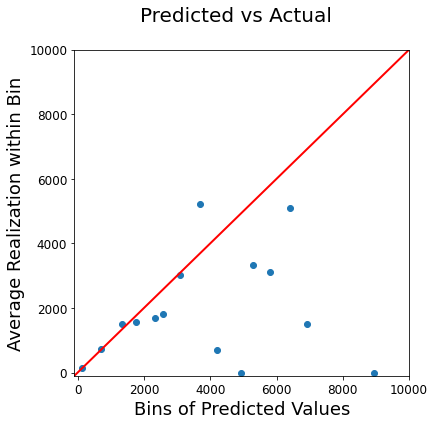

In [65]:
predictions = pd.Series(dt_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

# Random forest

A random forest and the boosted trees may take a long time to run, particularly on the full dataset, so you should be careful what you run on the full dataset. If something is taking forever, you can hit the stop button in the toolbar or go to "Kernel -> Interrupt Kernel".

In [66]:
%%time
rf_model = RandomForestRegressor(n_estimators=500,
                                 max_features=.2,
                                 max_depth=5,
                                 min_samples_split=2500,
                                 min_impurity_decrease=.1,
                                 random_state=201,
                                 n_jobs=num_cpus)
rf_model.fit(X_tree_train, y_tree_train)

CPU times: user 1min 27s, sys: 271 ms, total: 1min 27s
Wall time: 5.91 s


RandomForestRegressor(max_depth=5, max_features=0.2, min_impurity_decrease=0.1,
                      min_samples_split=2500, n_estimators=500, n_jobs=16,
                      random_state=201)

We can also look at the feature importance.

In [67]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.292949
FIRST_TIME_HOME_BUYER_INDICATOR(N):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.224015
DTI,0.161974
ORIGINAL_LTV,0.146947
PROPERTY_STATE,0.084231
FIRST_TIME_HOME_BUYER_INDICATOR(Y):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.042501
FIRST_TIME_HOME_BUYER_INDICATOR(N),0.017184
FIRST_TIME_HOME_BUYER_INDICATOR(Y),0.016837
FIRST_TIME_HOME_BUYER_INDICATOR(OTHER):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.010202
FIRST_TIME_HOME_BUYER_INDICATOR(OTHER),0.003160


Now we can predict on our validation set.

In [68]:
rf_pred = rf_model.predict(X_tree_validation)

In [69]:
accuracy(df_validation['NET_LOSS'], rf_pred)

RMSE,Naive - RMSE
7417.744677,38.654959


Let's plot the binned predicted versus actual net loss.

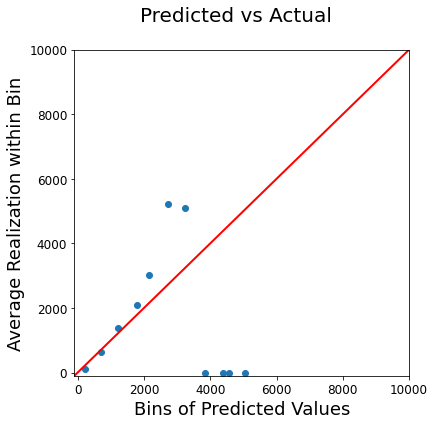

In [70]:
predictions = pd.Series(rf_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

# Boosted trees model

Let's look at a boosted trees model.

In [71]:
%%time
xgb_model = XGBRegressor(max_depth=6,
                         n_estimators = 50,
                         learning_rate=.1,
                         random_state=201,
                         n_jobs=num_cpus)
xgb_model.fit(X_tree_train, y_tree_train)

CPU times: user 34.6 s, sys: 784 ms, total: 35.4 s
Wall time: 2.23 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=201,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

We can also look at the feature importance.

In [72]:
pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
FIRST_TIME_HOME_BUYER_INDICATOR(Y):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.181046
BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.148748
ORIGINAL_LTV,0.112890
PROPERTY_STATE,0.112869
FIRST_TIME_HOME_BUYER_INDICATOR(N):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.111923
FIRST_TIME_HOME_BUYER_INDICATOR(OTHER):BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.102788
DTI,0.099971
FIRST_TIME_HOME_BUYER_INDICATOR(N),0.069575
FIRST_TIME_HOME_BUYER_INDICATOR(OTHER),0.034582
FIRST_TIME_HOME_BUYER_INDICATOR(Y),0.025608


Now we can predict on our validation set.

In [73]:
xgb_pred = xgb_model.predict(X_tree_validation)

In [74]:
accuracy(df_validation['NET_LOSS'], xgb_pred)

RMSE,Naive - RMSE
7407.692153,48.707483


Let's plot the binned predicted versus actual net loss.

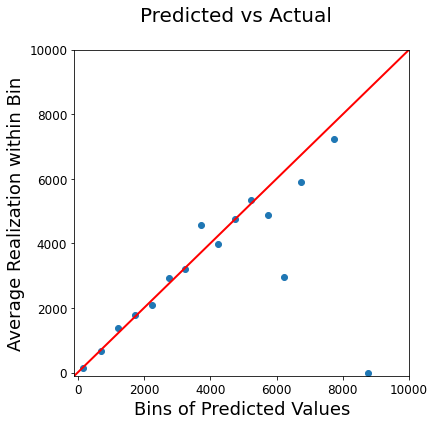

In [75]:
predictions = pd.Series(xgb_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

## Neural Networks

Neural networks are like tree based models in that they will automatically construct useful interactions through the hidden layers, but they are also like linear models in that order of inputs matter. Therefore, for neural networks it is best to create dummy variables for all the categorical variables and to standardize the continuous variables.

To transform the data, we will use `patsy` again. And the formula will look similar to the linear model formula.

In [98]:
formula_nn = "NET_LOSS ~ 0 + standardize(ORIGINAL_LTV) + standardize(DTI) + standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION) + FIRST_TIME_HOME_BUYER_INDICATOR + PROPERTY_STATE + standardize(YEAR)"

In [99]:
formula_nn

'NET_LOSS - 1 ~ 0 + standardize(ORIGINAL_LTV) + standardize(DTI) + standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION) + FIRST_TIME_HOME_BUYER_INDICATOR + PROPERTY_STATE + standardize(YEAR)'

Note that we do not include any interaction terms. You are free to do so, but neural networks can do a pretty good job of learning interactions. You may find that providing some pre-created interaction variables may still help, though.

We also, have `0 +` in the formula to keep the data from having an intercept term. Neural networks do not need intercepts.

Now we can build our X and y to train our model.

In [100]:
y_nn_train, X_nn_train = dmatrices(formula_nn, df_smaller_train, return_type="dataframe")

Let's look at what it made.

In [101]:
y_nn_train

,NET_LOSS
LOAN_IDENTIFIER,
366756076746,0.0
922055643120,0.0
567167163612,0.0
537298100693,0.0
414054555648,0.0
...,...
833696160226,0.0
943668997502,0.0
128751700926,0.0


In [102]:
X_nn_train

,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[Y],PROPERTY_STATE[T.AZ],PROPERTY_STATE[T.CA],PROPERTY_STATE[T.CO],PROPERTY_STATE[T.CT],PROPERTY_STATE[T.FL],PROPERTY_STATE[T.GA],PROPERTY_STATE[T.IA],PROPERTY_STATE[T.IL],PROPERTY_STATE[T.IN],PROPERTY_STATE[T.LA],PROPERTY_STATE[T.MA],PROPERTY_STATE[T.MD],PROPERTY_STATE[T.MI],PROPERTY_STATE[T.MN],PROPERTY_STATE[T.MO],PROPERTY_STATE[T.NC],PROPERTY_STATE[T.NJ],PROPERTY_STATE[T.NV],PROPERTY_STATE[T.NY],PROPERTY_STATE[T.OH],PROPERTY_STATE[T.OR],PROPERTY_STATE[T.OTHER],PROPERTY_STATE[T.PA],PROPERTY_STATE[T.SC],PROPERTY_STATE[T.TN],PROPERTY_STATE[T.TX],PROPERTY_STATE[T.UT],PROPERTY_STATE[T.VA],PROPERTY_STATE[T.WA],PROPERTY_STATE[T.WI],standardize(ORIGINAL_LTV),standardize(DTI),standardize(BORROWER_CREDIT_SCORE_AT_ORIGINATION),standardize(YEAR)
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
366756076746,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.880553,2.469771,-1.885060,-1.361281
922055643120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.026650,-1.207118,0.510588,-1.065033
567167163612,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709773,0.407126,0.686955,1.008706
537298100693,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.449823,0.586486,-2.105518,-0.472536
414054555648,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.051334,-1.296799,0.246038,-1.361281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833696160226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.311284,-0.938078,-0.062604,-0.916909
943668997502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.542619,0.945207,-0.753373,0.860582
128751700926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.620603,0.048405,1.201358,0.119961


We will go ahead and build the validation matrix. In order to test on our validation set, we have to perform the _exact same transformations on it_. First, we will use our `build_design_matrices` function to get our `X_nn_validation` matrix. Remember the `y` values for the validation set are just `df_validation['IsBadBuy']`.

In [103]:
X_nn_validation = build_design_matrices([X_nn_train.design_info], df_validation, return_type="dataframe")[0]

Now we can predict on the validation set after we have built out model.

Let's build a `MLPRegressor`.

In [104]:
%%time
nn_model = MLPRegressor(activation='relu', hidden_layer_sizes=(4,3), random_state=23)
nn_model.fit(X_nn_train, y_nn_train)

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2min 41s, sys: 18.9 ms, total: 2min 41s
Wall time: 2min 41s


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(4, 3), random_state=23)

And we can get our test predictions:

In [105]:
nn_pred = nn_model.predict(X_nn_validation)

And our score:

In [106]:
accuracy(df_validation['NET_LOSS'], nn_pred)

RMSE,Naive - RMSE
7149.211915,307.187721


Let's plot the binned predicted versus actual net loss.

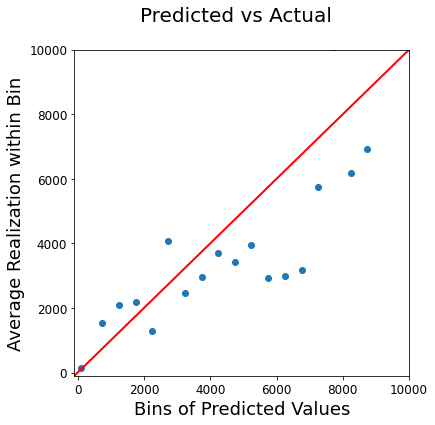

In [97]:
predictions = pd.Series(nn_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

## Predict on the Test Set

After you have gone through and chosen your specific model and the parameters from the model using your validation set, it is now time to go back and redo everything on the full training set in order to make predictions on the test set. Note that the below will assume you want to make the same choices around formatting data as you did for the `df_smaller_train` set above. The below is really just going through the above steps to create the data but replacing `df_smaller_train` with `df_train` and `df_validation` with `df_test`.

First, we will refit the imputers and impute on `df_train` and `df_test`.

In [ ]:
imputer_mean_final = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero_final = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer_final = CategoricalImputer(other_threshold=.01)

In [ ]:
imputer_mean_final.fit(df_train[continuous_mean])
df_train[continuous_mean] = imputer_mean_final.transform(df_train[continuous_mean])
df_test[continuous_mean] = imputer_mean_final.transform(df_test[continuous_mean])

In [ ]:
imputer_zero_final.fit(df_train[continuous_zero])
df_train[continuous_zero] = imputer_zero_final.transform(df_train[continuous_zero])
df_test[continuous_zero] = imputer_zero_final.transform(df_test[continuous_zero])

In [ ]:
categorical_imputer_final.fit(df_train[categorical_variables])
df_train[categorical_variables] = categorical_imputer_final.transform(df_train[categorical_variables])
df_test[categorical_variables] = categorical_imputer_final.transform(df_test[categorical_variables])

Now, we will re-create the linear regression data necessary to train and predict. This will use the same `formula_linear` you created when you were first training the logistic regression.

In [ ]:
y_linear_train_final, X_linear_train_final = dmatrices(formula_linear, df_train, return_type="dataframe")

Now we can build the `X_test` matrix in order to make final predictions from the linear regression models.

In [ ]:
X_test = build_design_matrices([X_linear_train_final.design_info], df_test, return_type="dataframe")[0]

Now, we can retrain the lasso regression model on the new data set. NOTE: You should adjust the parameters values to what you chose above.

In [ ]:
%%time
lasso_model_final = Lasso(alpha = 1, max_iter=1000000)
lasso_model_final.fit(X_linear_train_final, y_linear_train_final)

Let's make our final prediction with the LASSO model.

In [ ]:
lasso_pred_final = lasso_model_final.predict(X_test)

Let's do the same with the ridge model.

In [ ]:
%%time
ridge_model_final = Ridge(alpha = 1, max_iter=1000000)
ridge_model_final.fit(X_linear_train_final, y_linear_train_final)

Let's make our final prediction with the ridge model.

In [ ]:
ridge_pred_final = lasso_model_final.predict(X_test)

Now, we will recreate the tree based models data set.

In [ ]:
X_tree_train_final = df_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train_final = df_train['NET_LOSS']

If you created dummy variables or interactions, you will want to run the next line. If not, you can skip it. This will use the same `formula_tree` you made when first setting up the data set for trees.

In [ ]:
X_tree_train_patsy_final = dmatrix(formula_tree, df_train, return_type="dataframe")
X_tree_train_final = pd.concat([X_tree_train_final, X_tree_train_patsy_final], axis=1)

Now we ordinal encode variables. If you did not choose to ordinal encode any variables, you can skip this.

In [ ]:
ordinal_encoder_final = OrdinalEncoder()
ordinal_encoder_final.fit(X_tree_train_final[cat_ordinal_features_trees])
X_tree_train_final[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_train_final[cat_ordinal_features_trees])

Finally, we have to replace the characters that xgboost doesn't like.

In [ ]:
X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')

Now, we need to do these steps for the test set.

In [ ]:
X_tree_test = df_test[continuous_features_trees + cat_ordinal_features_trees]
y_tree_test = df_test['NET_LOSS']

X_tree_test_patsy = build_design_matrices([X_tree_train_patsy_final.design_info], df_test, return_type="dataframe")[0]

X_tree_test = pd.concat([X_tree_test, X_tree_test_patsy], axis=1)

X_tree_test[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_test[cat_ordinal_features_trees])

X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')

Now we can retrain our tree based models, and make final predictions. Note you should adjust parameters to whatever you found above, and you may not need to run all of the below code if you don't intend to use some of the models.

First, the decision tree.

In [ ]:
%%time
dt_model_final = DecisionTreeRegressor(max_depth=10,
                                       min_samples_split=2500,
                                       max_features=.5,
                                       min_impurity_decrease=.1,
                                       random_state=201)
dt_model_final.fit(X_tree_train_final, y_tree_train_final)
dt_pred_final = dt_model_final.predict(X_tree_test)

Second, the random forest.

In [ ]:
%%time
rf_model_final = RandomForestRegressor(n_estimators=500,
                                       max_features=.2,
                                       max_depth=5,
                                       min_samples_split=2500,
                                       min_impurity_decrease=.1,
                                       random_state=201,
                                       n_jobs=num_cpus)
rf_model_final.fit(X_tree_train_final, y_tree_train_final)
rf_pred_final = rf_model_final.predict(X_tree_test)

Finally, the boosted tree.

In [ ]:
%%time
xgb_model_final = XGBRegressor(max_depth=6,
                               n_estimators = 50,
                               learning_rate=.1,
                               random_state=201,
                               n_jobs=num_cpus)
xgb_model_final.fit(X_tree_train_final, y_tree_train_final)
xgb_pred_final = xgb_model_final.predict(X_tree_test)

Now we can create the data set necessary for the neural network and train that as well.

In [ ]:
y_nn_train_final, X_nn_train_final = dmatrices(formula_nn, df_train, return_type="dataframe")

In [ ]:
X_nn_test = build_design_matrices([X_nn_train_final.design_info], df_test, return_type="dataframe")[0]

We can now train our final neural network model. Remember to use the same parameters that you used when validating the model.

In [ ]:
%%time
nn_model_final = MLPRegressor(activation='relu', hidden_layer_sizes=(4,3), random_state=23)
nn_model_final.fit(X_nn_train_final, y_nn_train_final)

And predict on the test set:

In [ ]:
nn_pred_final = nn_model_final.predict(X_nn_test)

Now you can choose to ensemble however you would like. Below is one possibility of just ensembling all of the above models equally.

In [ ]:
final_pred = (lasso_pred_final + ridge_pred_final + dt_pred_final + rf_pred_final + xgb_pred_final + nn_pred_final)/6

Now, see you skill score on your final prediction.

In [ ]:
accuracy(df_test['NET_LOSS'], final_pred)

## Set a Threshold and Compute Revenue

Ultimately, we care about using the predictions of the model to decide whether or not to accept a mortgage application. Therefore, we have to decide what we consider to be too high of a probability of default before we reject a loan application. However, if we reject a loan application that does not default, we lose some potential revenue.

We will load in a fresh copy of the data to ensure we are computing the correct revenue.

In [ ]:
%%time
if not full_data_set:
    df_test_fresh = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')
elif full_data_set:
    df_test_fresh = pd.read_csv(FILES_LOCATION + "FannieMaeTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

One way of doing this is by setting a threshold where if the probability of default is lower than the threshold, accept the loan. Therefore, we can set the threshold either too high or too low. If it is too high, we lose out on potential revenue from accepting good loans, but if it too low, we take losses on loans that do default.

The below function will take in your predictions and a threshold, and it will produce a list of `True` and `False` values where `True` means you accept the loan and `False` means you do not accept the loan.

In [ ]:
def accept_by_predicted_loss(predictions, threshold):
    return predictions <= threshold

You can use it like below:

In [ ]:
loan_decisions = accept_by_predicted_loss(final_pred, 4000)

You can see that we end up accepting about 95% of the loans if we accept a predicted loss of \\$4000.

In [ ]:
loan_decisions.mean()

The `accept_by_predicted_loss` is one way to make this decision, and you are encouraged to think about other ways to do this.

The below function will take in your loan decisions and compute the revenue (in millions) from the accepted loans.

In [ ]:
def loan_loss_revenue(loans_accepted):
    revenue = (df_test_fresh[loan_decisions]['ORIGINAL_VALUE']*.005).sum() - df_test_fresh[loan_decisions]['NET_LOSS'].sum()
    return revenue/1000000

The revenue generated per loan is set at .5% of the original loan value. This is taken from the Quarterly Mortgage Bankers Performance Report, Q1 2018, where the average revenue per loan was about \\$1500. Since the average loan size in the Fannie Mae data set for 2018 was \\$330,000, this amounts to roughly .5% of the original loan value as revenue for the average mortgage banker in this time period. So, if you accept a loan (whether or not the loan ultimately defaults), the `loan_loss_revenue` will add .5% of the loan value for that loan.

However, if you accept a loan that does default, then the `NET_LOSS` of that loan will be subtracted from your total revenue.

This function allows you to compute the expected revenue from accepting your recommendations. You can use it as below.

In [ ]:
loan_loss_revenue(loan_decisions)

## Write out the data with your predictions

It is often helpful to take our predictions after we have made them, and visualize our errors to get a sense for how we might want to change and improve our model. Here we will append our predictions to the original testing set, and then we will write out the testing set with our predictions appended so that you can download the csv file and use Tableau to iterate on your model.

You will need the `df_test_fresh` data set loaded in the computing revenue section of this notebook. Once we have that you can add your predictions.

In [ ]:
df_test_fresh['PREDICTIONS_NET_LOSS'] = final_pred

Write out the csv of the data with your predictions. Download this csv from Jupyterhub and use this csv in Tableau to study your predictions geographically and try to determine where you might be making errors.

In [ ]:
df_test_fresh.to_csv('FannieMaeTestWithPredictionsNetLoss.csv', sep='|')

If you identify any systematic mistakes, then go back to the model building part of the exercise and try to correct them!